In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")
import gaupro
import gaupro.utils as uu
import gaupro.kernels as kernels
import gaupro.acquisition_functions as acq
import gaupro.policies as pol

## Balck-box function to be optimized

In [3]:
# train inputs
input_lim = [0, 20]
n_train = 1
d = 1
X = np.random.uniform(input_lim[0]+3.1, input_lim[1], n_train)
X = np.reshape(X, (d, n_train))

In [4]:
def black_box(x):
    return 4*np.exp(-(x-10)**2/100) * np.sin(x)

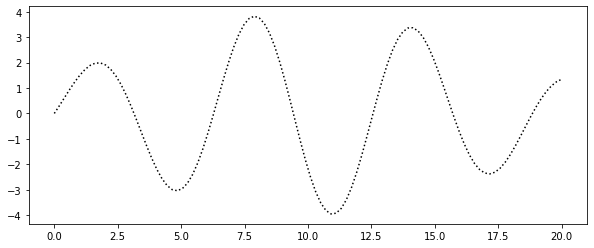

In [5]:
t = np.linspace(input_lim[0], input_lim[1], 100)

plt.figure(figsize=(10, 4))
plt.plot(t, black_box(t), c='k', linestyle=':')
plt.show()

In [6]:
y = black_box(X).reshape((n_train, 1))

In [7]:
# test inputs
n_test = 200
x_test = np.linspace(input_lim[0], input_lim[1], n_test).reshape((d, n_test))

In [8]:
# Train with some initial points
model = gaupro.Regressor(kernels.se_kernel(0.3))
model.fit(X, y)
mu, cov = model.predict(x_test)

## Bayesian Optimizer

In [9]:
optimizer = gaupro.BayesianOptimizer(model, black_box,
                                     acquisition_func=acq.PI(0.1),
                                     policy=pol.max_policy)

## Visualize optimal samples according to policy

In [10]:
%matplotlib notebook

<IPython.core.display.Javascript object>


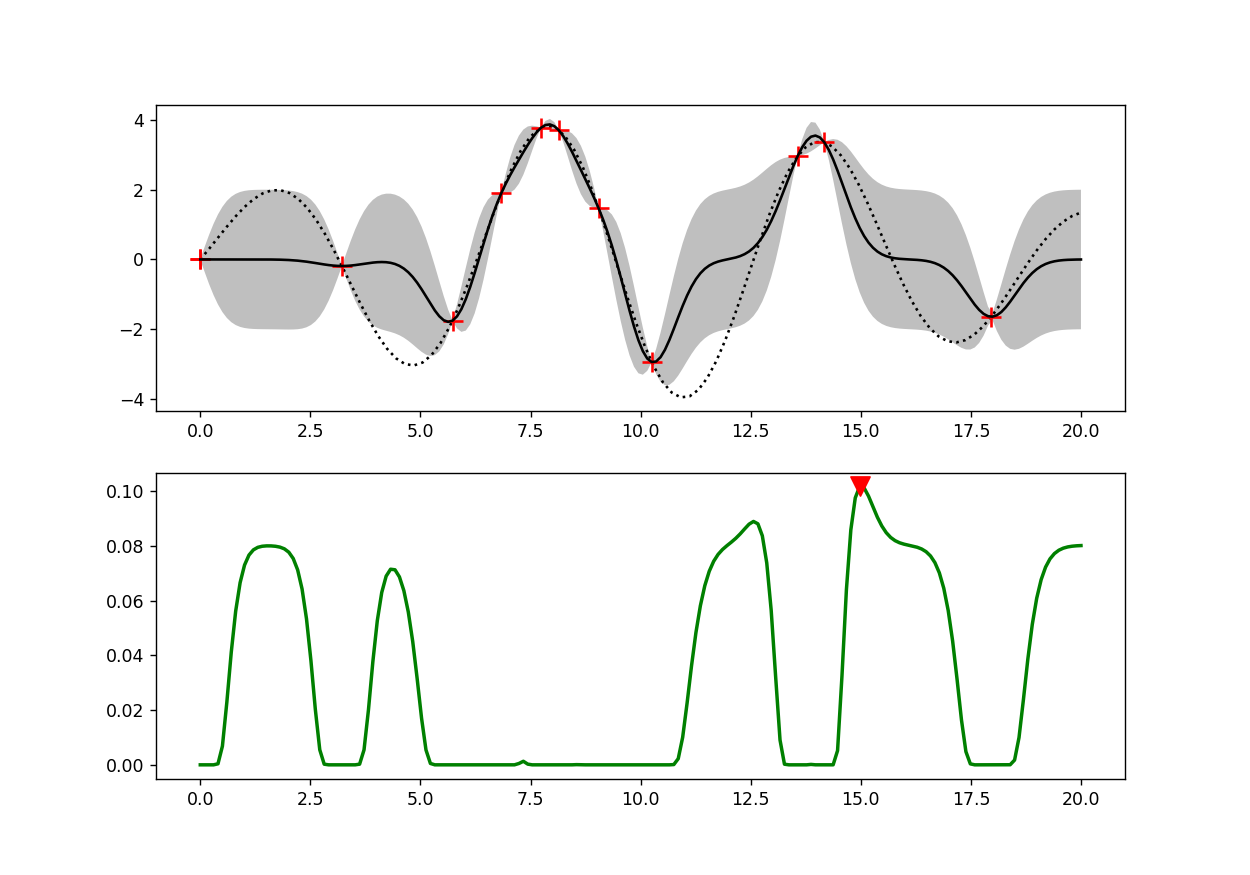

In [11]:
plt.ion()
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
t = np.linspace(input_lim[0], input_lim[1], 100)

for i in range(10):
    ax[0].cla()
    ax[1].cla()
    
    optimizer.update(x_test)

    ax[0].plot(t, black_box(t), c='k', linestyle=':')
    ax[0].scatter(optimizer.history[0, :], optimizer.history[1, :], marker='+', c='r', s=120, zorder=10)
    ax[0].plot(model.X_test.T, model.mu, c='k', zorder=10)
    ax[0].fill_between(model.X_test[0, :], model.mu[:, 0] - 2 * np.sqrt(np.abs(model.cov[np.diag_indices_from(model.cov)])),
                       model.mu[:, 0] + 2 * np.sqrt(np.abs(model.cov[np.diag_indices_from(model.cov)])),
                       facecolor='gray',
                       alpha=0.5)

    ax[1].plot(model.X_test.T, optimizer.acquisition_func(model.mu, model.cov), c='g', linewidth=2)
    if optimizer.i_next is not None:
        ax[1].scatter(optimizer.x_next, optimizer.acquisition_func(model.mu, model.cov)[optimizer.i_next],
                      marker='v', c='r', s=120, zorder=10)

    fig.canvas.draw()
    plt.pause(1)